# 07. Age-depth model
These age depth constraints on this core come from a number of sources. This notebook just joins these various sources of data (radiocarbon ages, LR04 timepoints from the previous notebook, magnetics), heirarchizes them, and joins them into a single table of age-depth tie points that can be used to generate an age model.

## Setup
### Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import interpolate
from scipy import signal
from scipy import stats

### Set Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'

## Prepare Age Model

### Benthic d18O

In [4]:
lr04=pd.read_csv(checkpoints_path+'lr04_tie_points.csv').iloc[1:]
lr04['Kind']='LR04'

### Paleomagnetic Data

In [27]:
pmg_age=pd.read_csv(data_path+'U1474/magnetic_stratigraphy.csv')
pmg_age=pmg_age.drop(labels=47)
pmg_age=pmg_age.set_index('Age (Myr)',drop=False)

#### Select only reversals and RPI older than 1.2

In [28]:
mag=pd.concat([pmg_age.where(pmg_age['Kind']=='RPI'),
               pmg_age.where(pmg_age['Kind']=='Reversal')]).dropna().sort_index()
mag.loc[0]=pmg_age.loc[0]
mag.sort_index(inplace=True)
mag['Sedimentation Rate']=((pmg_age['Depth CCSF (m)']-pmg_age['Depth CCSF (m)'].shift(1))/
                         (pmg_age['Age (Myr)']-pmg_age['Age (Myr)'].shift(1)))

In [29]:
mag['Age (kyr)']=mag['Age (Myr)']*1000
amearly=mag[mag['Depth CCSF (m)']>48.84].copy()

## Combine 14C, LR04 and paleomag tiepoints

In [30]:
combam=pd.concat([c14[['Depth CCSF (m)','Age (kyr)','Kind']],
                  lr04[['Depth CCSF (m)','Age (kyr)','Kind']],
                  amearly[['Depth CCSF (m)','Age (kyr)','Kind']]],axis=0)

In [31]:
combam['Sedimentation Rate']=((combam['Depth CCSF (m)']-combam['Depth CCSF (m)'].shift(1))/
                         (combam['Age (kyr)']-combam['Age (kyr)'].shift(1)))*100

In [32]:
am=interpolate.interp1d(combam['Depth CCSF (m)'],combam['Age (kyr)'],bounds_error=False)

In [33]:
combam=combam.reset_index().drop('index',axis=1).sort_values(by='Depth CCSF (m)')

## Sedimentation Rates

In [34]:
sr=pd.DataFrame(index=np.linspace(0,5500,10000))
sr['sr']=combam.set_index('Age (kyr)').reindex(sr.index,method='nearest')['Sedimentation Rate']

## Plot

/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_27592/100399412.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  lax1=plt.subplot(gs0[:2,0])


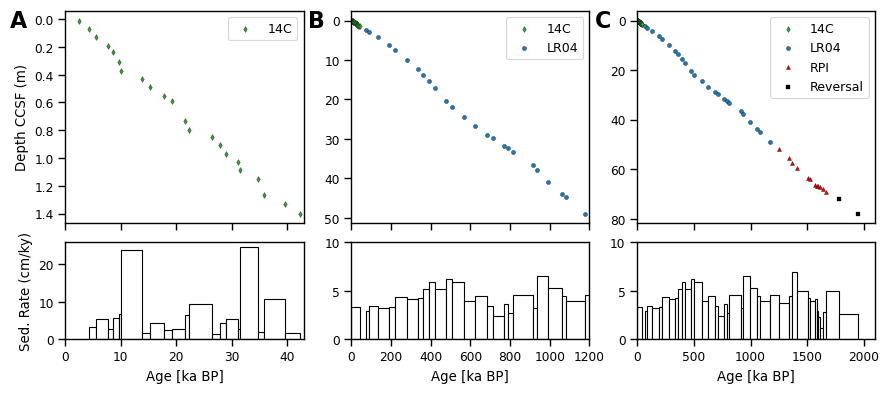

In [35]:
import matplotlib.gridspec as gridspec
fig,ax=plt.subplots(figsize=(9,4),facecolor='white')
sns.set_context('paper')
gs0 = gridspec.GridSpec(3,3,figure=fig,hspace=.2,wspace=.2)

lax1=plt.subplot(gs0[:2,0])
lax2=plt.subplot(gs0[2,0])

max1=plt.subplot(gs0[:2,1])
max2=plt.subplot(gs0[2,1])

rax1=plt.subplot(gs0[:2,2])
rax2=plt.subplot(gs0[2,2])

s=9

####### left

lax1.invert_yaxis()

df=combam[combam['Kind']=='14C']
lax1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='tab:green',marker='d',label='14C',s=s,ec='k',lw=.2)

lax1.set_ylabel('Depth CCSF (m)')
lax2.set_ylabel('Sed. Rate (cm/ky)')
lax1.legend(fontsize=9)
lax1.set_xlim(0,43)
lax1.set_xticklabels([])

########## left sed rates
# (sr['sr']).loc[0:40].plot(ax=lax2,color='k')
lax2.bar(df['Age (kyr)'],df['Sedimentation Rate'],width=(df['Age (kyr)'].shift(-1)-df['Age (kyr)']),
       facecolor='w',edgecolor='k',align='edge')
lax2.set_xlim(0,43)
lax2.set_xlabel('Age [ka BP]')




####### middle

max1.invert_yaxis()

df=combam[combam['Kind']=='14C']
max1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='tab:green',marker='d',label='14C',s=s,ec='k',lw=.2)

df=combam[combam['Kind']=='LR04']
max1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='tab:blue',marker='o',label='LR04',s=s,ec='k',lw=.2)

max1.legend(fontsize=9)
max1.set_xlim(0,1200)
max1.set_xticklabels([])

########## middle sed rates
df=combam[combam['Age (kyr)'].between(43,2100)]
c14m=combam[combam['Kind']=='14C']
max2.bar(0,140/42,42,facecolor='w',edgecolor='k',align='edge')
max2.bar(df['Age (kyr)'],df['Sedimentation Rate'],width=(df['Age (kyr)'].shift(-1)-df['Age (kyr)']),
       facecolor='w',edgecolor='k',align='edge')
max2.set_xlabel('Age [ka BP]')
max2.set_ylim(0,10)
max2.set_xlim(0,1200)


####### right

rax1.invert_yaxis()

df=combam[combam['Kind']=='14C']
rax1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='tab:green',marker='d',label='14C',s=s,ec='k',lw=.2)

df=combam[combam['Kind']=='LR04']
rax1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='tab:blue',marker='o',label='LR04',s=s,ec='k',lw=.2)

df=combam[(combam['Kind']=='RPI')&(combam['Age (kyr)']<2100)]
rax1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='xkcd:red',marker='^',label='RPI',s=s,ec='k',lw=.2)

df=combam[(combam['Kind']=='Reversal')&(combam['Age (kyr)']<2100)]
rax1.scatter(df['Age (kyr)'],df['Depth CCSF (m)'],color='k',marker='s',label='Reversal',s=s,ec='k',lw=.2)

rax1.legend(fontsize=9)
rax1.set_xlim(0,2100)
rax1.set_xticklabels([])


########## right sed rates
df=combam[combam['Age (kyr)'].between(43,2100)]
rax2.bar(0,140/42,42,facecolor='w',edgecolor='k',align='edge')
rax2.bar(df['Age (kyr)'],df['Sedimentation Rate'],width=(df['Age (kyr)'].shift(-1)-df['Age (kyr)']),
       facecolor='w',edgecolor='k',align='edge')
rax2.set_xlabel('Age [ka BP]')
rax2.set_ylim(0,10)
rax2.set_xlim(0,2100)


lax1.annotate('A',xy=(-.16,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
            fontsize=16)
max1.annotate('B',xy=(-.11,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
            fontsize=16)
rax1.annotate('C',xy=(-.11,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
            fontsize=16)

plt.subplots_adjust(left=0.07,right=.97,bottom=.13,top=.95)
fig.savefig(sup_figure_path+'Sup Figure 4 Age-Depth Model.png',dpi=300)

# Export

In [41]:
combam.to_csv(table_path+'Supplementary Table 2 - Age-depth model.csv',index=False)